**10장 – 케라스를 사용한 인공 신경망 소개**

_이 노트북에는 10장의 모든 샘플 코드와 연습 문제에 대한 솔루션이 포함되어 있습니다._

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/rickiepark/handson-ml3/blob/main/10_neural_nets_with_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

# 10.0 설정

이 프로젝트에는 Python 3.7 이상이 필요합니다:

In [1]:
import sys

assert sys.version_info >= (3, 7)

또한 Scikit-Learn ≥ 1.0.1이 필요합니다:

In [2]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

그리고 TensorFlow ≥ 2.8:

In [3]:
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

이전 챕터에서와 마찬가지로 기본 글꼴 크기를 정의하여 그림을 더 예쁘게 만들어 보겠습니다:

In [4]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

import sys
# 코랩의 경우 나눔 폰트를 설치합니다.
if 'google.colab' in sys.modules:
    !sudo apt-get -qq -y install fonts-nanum
    import matplotlib.font_manager as fm
    font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])
    for fpath in font_files:
        fm.fontManager.addfont(fpath)

# 나눔 폰트를 사용합니다.
import matplotlib

matplotlib.rc('font', family='NanumBarunGothic')
matplotlib.rcParams['axes.unicode_minus'] = False

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 123629 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


그리고 `images/ann` 폴더를 만들고(아직 존재하지 않는 경우), 이 노트북을 통해 책에 사용할 그림을 고해상도로 저장하는 데 사용되는 `save_fig()` 함수를 정의해 보겠습니다:

In [5]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "ann"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 10.1 생물학적 뉴런에서 인공 뉴런까지

## 10.1.3 퍼셉트론

In [6]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris(as_frame=True)
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = (iris.target == 0)  # Iris setosa

# Perceptron 모델을 훈련합니다.

per_clf = Perceptron(random_state=42)
per_clf.fit(X, y)

X_new = [[2, 0.5], [3, 1]]
y_pred = per_clf.predict(X_new)  # 두 개의 꽃에 대해 True과 False를 예측합니다.

In [7]:
y_pred

array([ True, False])

`Perceptron`은 `loss="perceptron"`, 정규화 없음, 학습률이 일정하게 1인 `SGDClassifier`와 동일합니다:

In [8]:
# 추가 코드 - 퍼셉트론을 구축하고 훈련하는 방법을 보여줍니다.

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss="perceptron", penalty=None,
                        learning_rate="constant", eta0=1, random_state=42)
sgd_clf.fit(X, y)
assert (sgd_clf.coef_ == per_clf.coef_).all()
assert (sgd_clf.intercept_ == per_clf.intercept_).all()

퍼셉트론이 클래스를 적절히 구분하는 결정 경계를 찾으면 학습을 중단합니다. 이는 결정 경계가 종종 한 클래스에 매우 가깝다는 것을 의미합니다:

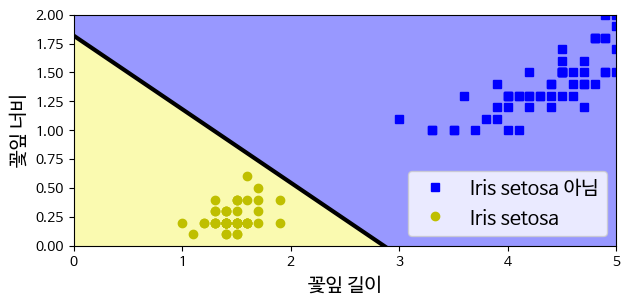

In [9]:
# 추가 코드 - 붓꽃 데이터 세트에 대한 퍼셉트론의 결정 경계를 표시합니다.

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

a = -per_clf.coef_[0, 0] / per_clf.coef_[0, 1]
b = -per_clf.intercept_ / per_clf.coef_[0, 1]
axes = [0, 5, 0, 2]
x0, x1 = np.meshgrid(
    np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
    np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
)
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.figure(figsize=(7, 3))
plt.plot(X[y == 0, 0], X[y == 0, 1], "bs", label="Iris setosa 아님")
plt.plot(X[y == 1, 0], X[y == 1, 1], "yo", label="Iris setosa")
plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-",
         linewidth=3)
plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("꽃잎 길이")
plt.ylabel("꽃잎 너비")
plt.legend(loc="lower right")
plt.axis(axes)
plt.show()

**활성화 함수**

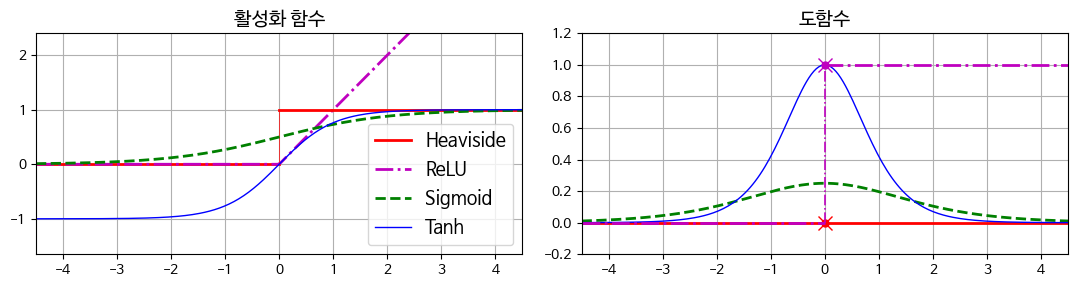

In [10]:
# 추가 코드 - 이 셀은 그림 10-8을 생성하고 저장합니다.

from scipy.special import expit as sigmoid

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

max_z = 4.5
z = np.linspace(-max_z, max_z, 200)

plt.figure(figsize=(11, 3.1))

plt.subplot(121)
plt.plot([-max_z, 0], [0, 0], "r-", linewidth=2, label="Heaviside")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.plot([0, 0], [0, 1], "r-", linewidth=0.5)
plt.plot([0, max_z], [1, 1], "r-", linewidth=2)
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=1, label="Tanh")
plt.grid(True)
plt.title("활성화 함수")
plt.axis([-max_z, max_z, -1.65, 2.4])
plt.gca().set_yticks([-1, 0, 1, 2])
plt.legend(loc="lower right", fontsize=13)

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=2, label="Heaviside")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=1, label="Tanh")
plt.plot([-max_z, 0], [0, 0], "m-.", linewidth=2)
plt.plot([0, max_z], [1, 1], "m-.", linewidth=2)
plt.plot([0, 0], [0, 1], "m-.", linewidth=1.2)
plt.plot(0, 1, "mo", markersize=5)
plt.plot(0, 1, "mx", markersize=10)
plt.grid(True)
plt.title("도함수")
plt.axis([-max_z, max_z, -0.2, 1.2])

save_fig("activation_functions_plot")
plt.show()

## 10.1.5 회귀 MLP

In [11]:
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

# MLPRegressor 모델을 훈련합니다.
# Slide 23

mlp_reg = MLPRegressor(hidden_layer_sizes=[50, 50, 50], random_state=42)
pipeLine = make_pipeline(StandardScaler(), mlp_reg)
pipeLine.fit(X_train, y_train)
y_pred = pipeLine.predict(X_valid)
rmse = mean_squared_error(y_valid, y_pred, squared=False) # 약 0.505

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [12]:
rmse

0.5053326657968128

## 10.1.6 분류 MLP

In [13]:
# 추가 코드 - 이것은 독자를 위한 연습으로 남겨두었습니다.

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

iris = load_iris()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    iris.data, iris.target, test_size=0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.1, random_state=42)

mlp_clf = MLPClassifier(hidden_layer_sizes=[5], max_iter=10_000,
                        random_state=42)
pipeline = make_pipeline(StandardScaler(), mlp_clf)
pipeline.fit(X_train, y_train)
accuracy = pipeline.score(X_valid, y_valid)
accuracy

1.0

# 10.2 케라스로 MLP 구현하기

## 10.2.1 시퀀셜 API를 사용하여 이미지 분류기 만들기

### 케라스를 사용하여 데이터셋 적재하기

먼저 패션 MNIST 데이터셋을 로드해 보겠습니다. 케라스에는 `tf.keras.datasets`에서 인기 있는 데이터셋을 로드하는 여러 함수를 제공합니다. 이 데이터셋은 이미 훈련 세트(60,000개 이미지)와 테스트 세트(10,000개 이미지)로 분할되어 있습니다. 하지만 훈련 세트를 더 분할하여 검증 세트를 만드는 것이 좋습니다. 훈련에는 55,000개의 이미지를, 검증에는 5,000개의 이미지를 사용하겠습니다.

In [14]:
import tensorflow as tf

fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


훈련 세트에는 각각 28x28픽셀의 55,000개의 흑백 이미지가 포함되어 있습니다:

In [15]:
X_train.shape

(55000, 28, 28)

각 픽셀 강도는 한 바이트(0~255)로 표시됩니다:

In [16]:
X_train.dtype

dtype('uint8')

픽셀 강도를 0-1 범위로 축소하기 위해 255로 나누겠습니다:

In [17]:
X_train, X_valid, X_test = X_train / 255., X_valid / 255., X_test / 255.

Matplotlib의 `imshow()` 함수를 사용하여 `'binary'` 컬러 맵으로 이미지를 플로팅할 수 있습니다:

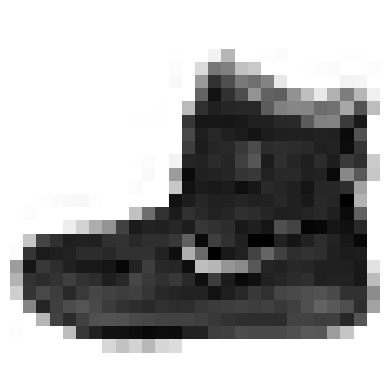

In [18]:
# 추가 코드

plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

레이블은 0에서 9까지의 클래스 ID(uint8로 표시)입니다:

In [19]:
y_train

array([9, 0, 0, ..., 9, 0, 2], dtype=uint8)

해당 클래스 이름은 다음과 같습니다:

In [20]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

따라서 훈련 세트의 첫 번째 이미지는 앵클부츠입니다:

In [21]:
class_names[y_train[5]]

'Pullover'

데이터셋에 있는 이미지 샘플을 살펴보겠습니다:

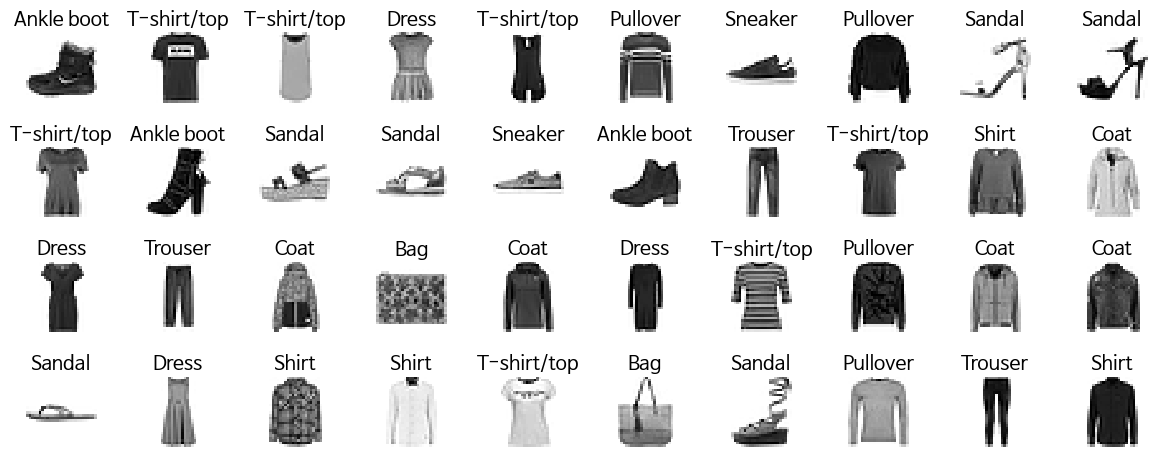

In [22]:
# 추가 코드 - 이 셀은 그림 10-10을 생성하고 저장합니다.

n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]])
plt.subplots_adjust(wspace=0.2, hspace=0.5)

save_fig("fashion_mnist_plot")
plt.show()

### 시퀀셜 API를 사용하여 모델 만들기

In [23]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
# model.add()...Slide 32
model.add(tf.keras.layers.Input(shape=[28, 28]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(300, activation="relu"))
model.add(tf.keras.layers.Dense(100, activation="relu"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [24]:
# 추가 코드 - 세션을 지워 이름 카운터를 재설정합니다.
tf.keras.backend.clear_session()
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [25]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 300)                 │         235,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 100)                 │          30,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           1,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 266,610 (1.02 MB)

 Trainable params: 266,610 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

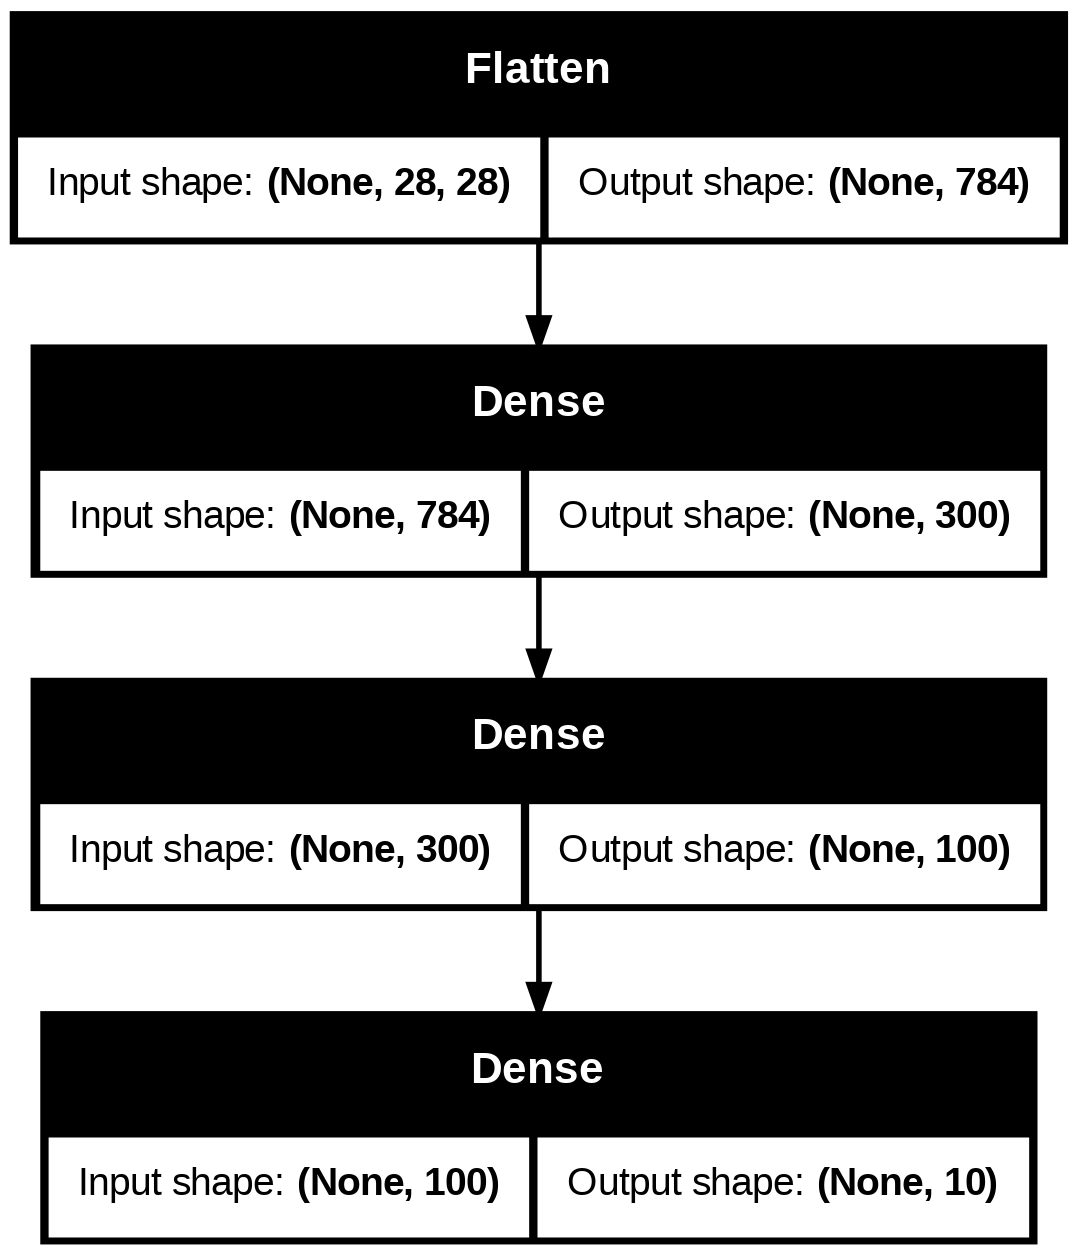

In [26]:
# 추가 코드 - 모델의 아키텍처를 표시하는 또 다른 방법
tf.keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

In [27]:
model.layers

[<Flatten name=flatten, built=True>,
 <Dense name=dense, built=True>,
 <Dense name=dense_1, built=True>,
 <Dense name=dense_2, built=True>]

In [28]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [29]:
model.get_layer('dense') is hidden1

True

In [30]:
weights, biases = hidden1.get_weights()
weights

array([[ 0.02847866, -0.00321288, -0.03354003, ..., -0.04879128,
         0.04997727,  0.04941174],
       [-0.03671012, -0.06851106,  0.06023796, ...,  0.04842965,
         0.07013044, -0.02958367],
       [-0.01520886, -0.05669355, -0.06773313, ...,  0.05233753,
        -0.07216477, -0.06538516],
       ...,
       [ 0.05226462,  0.06938347, -0.05395328, ...,  0.02829399,
         0.0513301 ,  0.03025281],
       [-0.0676621 , -0.02751599, -0.05801694, ..., -0.02981492,
         0.01372541,  0.06524453],
       [ 0.02093824,  0.00617522,  0.06360383, ..., -0.01415021,
        -0.0120733 , -0.06121557]], dtype=float32)

In [31]:
weights.shape

(784, 300)

In [32]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [33]:
biases.shape

(300,)

### 모델 컴파일

In [34]:
# model.compile()...Slide 36

model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics = ["accuracy"])

이는 다음과 같습니다:

In [35]:
# 추가 코드 - 이 셀은 이전 셀과 동일합니다.
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
              optimizer=tf.keras.optimizers.SGD(),
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])

In [36]:
# 추가 코드 - 클래스 ID를 원핫 벡터로 변환하는 방법을 보여줍니다.
tf.keras.utils.to_categorical([0, 5, 1, 0], num_classes=10)

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

참고: 클래스 수가 샘플의 클래스 ID 최댓값보다 클 경우 `num_classes`를 설정하는 것이 중요합니다.

In [37]:
# 추가 코드 - 원핫 벡터를 클래스 ID로 변환하는 방법을 보여줍니다.
np.argmax(
    [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
     [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
     [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
     [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
    axis=1
)

array([0, 5, 1, 0])

### 모델 훈련 및 평가

In [38]:
# history = model.fit()...Slide 37
history = model.fit(X_train, y_train, epochs=30,
                    validation_data = (X_valid, y_valid))

Epoch 1/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 1.0020 - sparse_categorical_accuracy: 0.6878 - val_loss: 0.5101 - val_sparse_categorical_accuracy: 0.8288
Epoch 2/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.5078 - sparse_categorical_accuracy: 0.8260 - val_loss: 0.4556 - val_sparse_categorical_accuracy: 0.8352
Epoch 3/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4529 - sparse_categorical_accuracy: 0.8432 - val_loss: 0.4295 - val_sparse_categorical_accuracy: 0.8458
Epoch 4/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.4216 - sparse_categorical_accuracy: 0.8548 - val_loss: 0.4123 - val_sparse_categorical_accuracy: 0.8526
Epoch 5/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.3991 - sparse_categorical_accuracy: 0.8623 - val_loss: 0.4004 - val_sparse_categorical_accuracy: 0.8580
Epoch 6/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.3816 - sparse_categorical_accuracy: 0.8670 - val_loss: 0.3897 - val_sparse_categorical_accuracy:

In [39]:
history.params

{'verbose': 'auto', 'epochs': 30, 'steps': 1719}

In [40]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


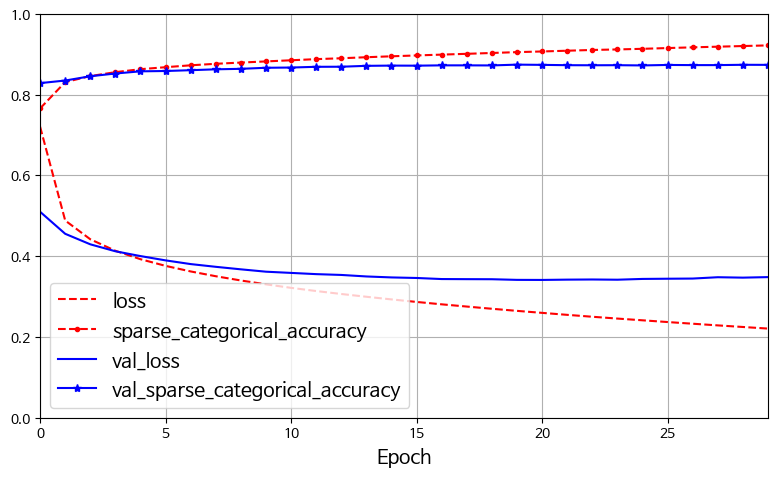

In [41]:
import matplotlib.pyplot as plt
import pandas as pd

pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, 29], ylim=[0, 1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.legend(loc="lower left")  # 추가 코드
save_fig("keras_learning_curves_plot")  # 추가 코드
plt.show()

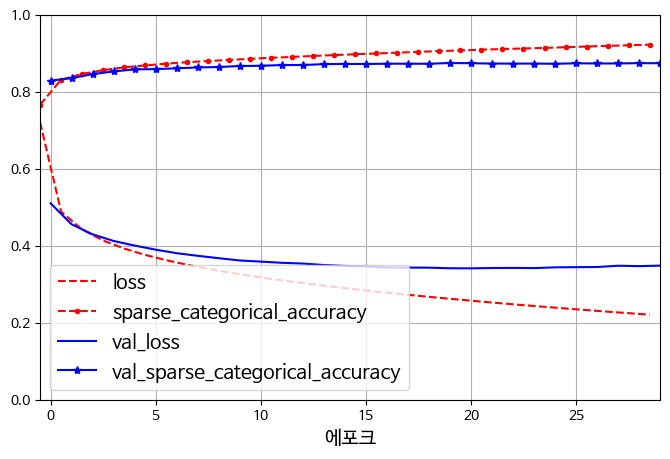

In [42]:
# 추가 코드 - 훈련 곡선을 -1/2 에포크로 이동하는 방법을 보여줍니다.
plt.figure(figsize=(8, 5))
for key, style in zip(history.history, ["r--", "r--.", "b-", "b-*"]):
    epochs = np.array(history.epoch) + (0 if key.startswith("val_") else -0.5)
    plt.plot(epochs, history.history[key], style, label=key)
plt.xlabel("에포크")
plt.axis([-0.5, 29, 0., 1])
plt.legend(loc="lower left")
plt.grid()
plt.show()

In [43]:
model.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.3703 - sparse_categorical_accuracy: 0.8745


[0.36868223547935486, 0.8738999962806702]

### 모델을 사용하여 예측하기

In [44]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.11, 0.  , 0.02, 0.  , 0.88],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [45]:
y_pred = y_proba.argmax(axis=-1)
y_pred

array([9, 2, 1])

In [46]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [47]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

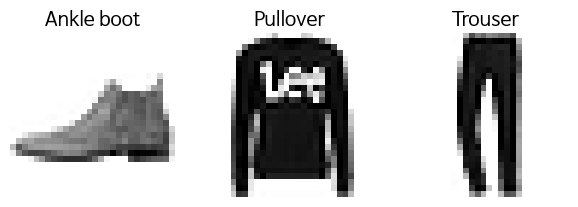

In [48]:
# 추가 코드 - 이 셀은 그림 10-12를 생성하고 저장합니다.
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()

## 10.2.2 시퀀셜 API를 사용하여 회귀 MLP 만들기

캘리포니아 주택 데이터셋(2장에서와 같이 수정된 데이터셋이 아닌 원본 데이터셋)을 로드하고, 분할하고, 스케일을 조정해 보겠습니다:

In [49]:
# 추가 코드 - 이전과 같이 캘리포니아 주택 데이터 집합을 로드하고 분할합니다.
housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

In [50]:
tf.random.set_seed(42)
norm_layer = tf.keras.layers.Normalization(input_shape=X_train.shape[1:])

# slide 42
model = tf.keras.Sequential([
    norm_layer,
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(1)])


optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])
norm_layer.adapt(X_train)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test, rmse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - RootMeanSquaredError: 1.2924 - loss: 1.7987 - val_RootMeanSquaredError: 1.0192 - val_loss: 1.0387
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - RootMeanSquaredError: 0.6284 - loss: 0.3954 - val_RootMeanSquaredError: 0.9651 - val_loss: 0.9314
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - RootMeanSquaredError: 0.6018 - loss: 0.3624 - val_RootMeanSquaredError: 0.8024 - val_loss: 0.6438
Epoch 4/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - RootMeanSquaredError: 0.5918 - loss: 0.3504 - val_RootMeanSquaredError: 0.6022 - val_loss: 0.3627
Epoch 5/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - RootMeanSquaredError: 0.5853 - loss: 0.3427 - val_RootMeanSquaredError: 1.0583 - val_loss: 1.1199
Epoch 6/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - RootMeanSquaredError: 0.5752 - loss: 0.3310 - val_RootMeanSquaredError: 1.2629 - val_loss: 1.5949
Epoch 7/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.5704 - lo

In [51]:
rmse_test

0.537995457649231

In [52]:
y_pred

array([[0.42199385],
       [0.85381925],
       [5.145062  ]], dtype=float32)

## 10.2.3 함수형 API를 사용하여 복잡한 모델 구축

모든 신경망 모델이 단순히 순차적인 구조를 가지지 않습니다. 일부는 복잡한 토폴로지를 가질 수 있습니다. 일부는 여러 개의 입력 및/또는 여러 개의 출력을 가질 수 있습니다. 예를 들어, 와이드 & 딥 신경망([논문](https://ai.google/research/pubs/pub45413) 참조)은 입력의 전부 또는 일부를 출력 레이어에 직접 연결합니다.

In [53]:
# 추가 코드 - 이름 카운터를 재설정하고 코드를 재현 가능하게 만듭니다.
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [54]:
# Slide 45
normalization_layer = tf.keras.layers.Normalization()
hidden_layer1 = tf.keras.layers.Dense(30, activation="relu")
hidden_layer2 = tf.keras.layers.Dense(30, activation="relu")
concat_layer = tf.keras.layers.Concatenate()
output_layer = tf.keras.layers.Dense(1)

input_ = tf.keras.layers.Input(shape=X_train.shape[1:])
normalized = normalization_layer(input_)
hidden1 = hidden_layer1(normalized)
hidden2 = hidden_layer2(hidden1)
concat = concat_layer([normalized, hidden2])
output = output_layer(concat)

model = tf.keras.Model(inputs=[input_], outputs=[output])

In [55]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 8)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 8)              │             17 │ input_layer[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 30)             │            270 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 30)             │            930 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 38)             │              0 │ normalization[0][0],   │
│                           │                        │                │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1)              │             39 │ concatenate[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,256 (4.91 KB)

 Trainable params: 1,239 (4.84 KB)

 Non-trainable params: 17 (72.00 B)

In [56]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])


normalization_layer.adapt(X_train)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_new)

Epoch 1/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - RootMeanSquaredError: 1.2747 - loss: 1.7222 - val_RootMeanSquaredError: 0.8208 - val_loss: 0.6737
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - RootMeanSquaredError: 0.6898 - loss: 0.4774 - val_RootMeanSquaredError: 0.9014 - val_loss: 0.8126
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.6359 - loss: 0.4048 - val_RootMeanSquaredError: 0.9487 - val_loss: 0.9001
Epoch 4/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - RootMeanSquaredError: 0.6195 - loss: 0.3841 - val_RootMeanSquaredError: 1.0298 - val_loss: 1.0605
Epoch 5/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - RootMeanSquaredError: 0.6119 - loss: 0.3746 - val_RootMeanSquaredError: 1.1885 - val_loss: 1.4125
Epoch 6/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - RootMeanSquaredError: 0.6067 - loss: 0.3683 - val_RootMeanSquaredError: 1.3335 - val_loss: 1.7781
Epoch 7/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - RootMeanSquaredError: 0.6026 - los

와이드 또는 딥 경로를 통해 입력 특성의 일부를 각기 다르게 보내려면 어떻게 해야 하나요? 5개의 특성(특성 0~4)와 6개의 특성을 딥 경로(특성 2~7)를 통해 전달하겠습니다. 3개의 특성(특성 2, 3, 4)은 양쪽을 모두 통과합니다.

In [57]:
tf.random.set_seed(42)  # 추가 코드

In [58]:
input_wide = tf.keras.layers.Input(shape=[5])  # 특성 0 ~ 4
input_deep = tf.keras.layers.Input(shape=[6])  # 특성 2 ~ 7
norm_layer_wide = tf.keras.layers.Normalization()
norm_layer_deep = tf.keras.layers.Normalization()
norm_wide = norm_layer_wide(input_wide)
norm_deep = norm_layer_deep(input_deep)
hidden1 = tf.keras.layers.Dense(30, activation="relu")(norm_deep)
hidden2 = tf.keras.layers.Dense(30, activation="relu")(hidden1)
concat = tf.keras.layers.concatenate([norm_wide, hidden2])
output = tf.keras.layers.Dense(1)(concat)
model = tf.keras.Model(inputs=[input_wide, input_deep], outputs=[output])

In [59]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])

X_train_wide, X_train_deep = X_train[:, :5], X_train[:, 2:]
X_valid_wide, X_valid_deep = X_valid[:, :5], X_valid[:, 2:]
X_test_wide, X_test_deep = X_test[:, :5], X_test[:, 2:]
X_new_wide, X_new_deep = X_test_wide[:3], X_test_deep[:3]

norm_layer_wide.adapt(X_train_wide)
norm_layer_deep.adapt(X_train_deep)
history = model.fit((X_train_wide, X_train_deep), y_train, epochs=20,
                    validation_data=((X_valid_wide, X_valid_deep), y_valid))
mse_test = model.evaluate((X_test_wide, X_test_deep), y_test)
y_pred = model.predict((X_new_wide, X_new_deep))

Epoch 1/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - RootMeanSquaredError: 1.9233 - loss: 3.8649 - val_RootMeanSquaredError: 1.0593 - val_loss: 1.1222
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.8457 - loss: 0.7176 - val_RootMeanSquaredError: 0.7187 - val_loss: 0.5165
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.7064 - loss: 0.4993 - val_RootMeanSquaredError: 0.6629 - val_loss: 0.4394
Epoch 4/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.6690 - loss: 0.4479 - val_RootMeanSquaredError: 0.6292 - val_loss: 0.3959
Epoch 5/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.6480 - loss: 0.4201 - val_RootMeanSquaredError: 0.6129 - val_loss: 0.3756
Epoch 6/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.6343 - loss: 0.4026 - val_RootMeanSquaredError: 0.6048 - val_loss: 0.3658
Epoch 7/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - RootMeanSquaredError: 0.6245 - los

규제를 위한 보조 출력 추가:

In [60]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [61]:
input_wide = tf.keras.layers.Input(shape=[5])  # 특성 0 ~ 4
input_deep = tf.keras.layers.Input(shape=[6])  # 특성 2 ~ 7
norm_layer_wide = tf.keras.layers.Normalization()
norm_layer_deep = tf.keras.layers.Normalization()
norm_wide = norm_layer_wide(input_wide)
norm_deep = norm_layer_deep(input_deep)
hidden1 = tf.keras.layers.Dense(30, activation="relu")(norm_deep)
hidden2 = tf.keras.layers.Dense(30, activation="relu")(hidden1)
concat = tf.keras.layers.concatenate([norm_wide, hidden2])
output = tf.keras.layers.Dense(1)(concat)
aux_output = tf.keras.layers.Dense(1)(hidden2)
model = tf.keras.Model(inputs=[input_wide, input_deep],
                       outputs=[output, aux_output])

In [62]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss=("mse", "mse"), loss_weights=(0.9, 0.1), optimizer=optimizer,
              metrics=["RootMeanSquaredError"])

In [63]:
norm_layer_wide.adapt(X_train_wide)
norm_layer_deep.adapt(X_train_deep)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=20,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid))
)

Epoch 1/20


ValueError: For a model with multiple outputs, when providing the `metrics` argument as a list, it should have as many entries as the model has outputs. Received:
metrics=['RootMeanSquaredError']
of length 1 whereas the model has 2 outputs.

In [ ]:
eval_results = model.evaluate((X_test_wide, X_test_deep), (y_test, y_test))
weighted_sum_of_losses, main_loss, aux_loss, main_rmse, aux_rmse = eval_results

In [ ]:
y_pred_main, y_pred_aux = model.predict((X_new_wide, X_new_deep))

In [ ]:
y_pred_tuple = model.predict((X_new_wide, X_new_deep))
y_pred = dict(zip(model.output_names, y_pred_tuple))

## 10.2.4 서브클래싱 API를 사용하여 동적 모델 만들기

In [ ]:
class WideAndDeepModel(tf.keras.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs)  # 모델 이름을 지정하는 데 필요합니다
        # layers...slide 51
        self.norm_layer_wide = tf.keras.layers.Normalization()
        self.norm_layer_deep = tf.keras.layers.Normalization()
        self.hidden1 = tf.keras.layers.Dense(units, activation=activation)
        self.hidden2 = tf.keras.layers.Dense(units, activation=activation)
        self.main_output = tf.keras.layers.Dense(1)
        self.aux_output = tf.keras.layers.Dense(1)

    def call(self, inputs):
        input_wide, input_deep = inputs
        norm_wide = self.norm_layer_wide(input_wide)
        norm_deep = self.norm_layer_deep(input_deep)
        hidden1 = self.hidden1(norm_deep)
        hidden2 = self.hidden2(hidden1)
        concat = tf.keras.layers.concatenate([norm_wide, hidden2])
        output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return output, aux_output

tf.random.set_seed(42)  # 추가 코드 - 재현성을 위한 것
model = WideAndDeepModel(30, activation="relu", name="my_cool_model")

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", loss_weights=[0.9, 0.1], optimizer=optimizer,
              metrics=["RootMeanSquaredError"])
model.norm_layer_wide.adapt(X_train_wide)
model.norm_layer_deep.adapt(X_train_deep)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=10,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)))
eval_results = model.evaluate((X_test_wide, X_test_deep), (y_test, y_test))
weighted_sum_of_losses, main_loss, aux_loss, main_rmse, aux_rmse = eval_results
y_pred_main, y_pred_aux = model.predict((X_new_wide, X_new_deep))

## 10.2.5 모델 저장 및 복원

In [ ]:
# 추가 코드 - 이미 존재하는 경우 디렉토리를 삭제합니다.

import shutil

shutil.rmtree("my_keras_model", ignore_errors=True)

In [ ]:
model.save("my_keras_model", save_format="tf")

In [ ]:
# 추가 코드 - my_keras_model/ directory의 내용 표시
for path in sorted(Path("my_keras_model").glob("**/*")):
    print(path)

In [ ]:
model = tf.keras.models.load_model("my_keras_model")
y_pred_main, y_pred_aux = model.predict((X_new_wide, X_new_deep))

In [ ]:
model.save_weights("my_weights")

In [ ]:
model.load_weights("my_weights")

In [ ]:
# 추가 코드 - my_weights.* 파일 목록 표시
for path in sorted(Path().glob("my_weights.*")):
    print(path)

## 10.2.6 콜백 사용하기

In [ ]:
shutil.rmtree("my_checkpoints", ignore_errors=True)  # 추가 코드

In [ ]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_checkpoints",
                                                   save_weights_only=True)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=10,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)),
    callbacks=[checkpoint_cb])

In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=100,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)),
    callbacks=[checkpoint_cb, early_stopping_cb])

In [ ]:
class PrintValTrainRatioCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        ratio = logs["val_loss"] / logs["loss"]
        print(f"Epoch={epoch}, val/train={ratio:.2f}")

In [ ]:
val_train_ratio_cb = PrintValTrainRatioCallback()
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=10,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)),
    callbacks=[val_train_ratio_cb], verbose=0)

## 10.2.7 텐서보드를 사용해 시각화하기

콜랩에는 텐서보드가 미리 설치되어 있지만, `tensorboard-plugin-profile`은 설치되어 있지 않으므로 설치해 보겠습니다:

In [ ]:
import sys
if "google.colab" in sys.modules:  # 추가 코드
    %pip install -q -U tensorboard-plugin-profile

In [ ]:
import shutil
shutil.rmtree("my_logs", ignore_errors=True)

In [ ]:
from pathlib import Path
from time import strftime

def get_run_logdir(root_logdir="my_logs"):
    return Path(root_logdir) / strftime("run_%Y_%m_%d_%H_%M_%S")

run_logdir = get_run_logdir()

In [ ]:

# 추가 코드 - 앞서 사용한 첫 번째 회귀 모델을 만듭니다.
tf.keras.backend.clear_session()
tf.random.set_seed(42)
norm_layer = tf.keras.layers.Normalization(input_shape=X_train.shape[1:])
model = tf.keras.Sequential([
    norm_layer,
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(1)
])
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])
norm_layer.adapt(X_train)

In [ ]:
tensorboard_cb = tf.keras.callback.TensorBoard(
    run_logdir,
    profile_batch = (100, 200)
)
history = model.fit[...], callbacks=[tensorboard_cb]

In [ ]:
print("my_logs")
for path in sorted(Path("my_logs").glob("**/*")):
    print("  " * (len(path.parts) - 1) + path.parts[-1])

`tensorboard` 주피터 확장자를 로드하고 텐서보드 서버를 시작해 보겠습니다:

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs

**노트**: 별도의 탭에서 텐서보드에 액세스하려면 아래에 있는 "localhost:6006" 링크를 클릭하세요:

In [ ]:
# 추가 코드

if "google.colab" in sys.modules:
    from google.colab import output

    output.serve_kernel_port_as_window(6006)
else:
    from IPython.display import display, HTML

    display(HTML('<a href="http://localhost:6006/">http://localhost:6006/</a>'))

히스토그램, 이미지, 텍스트를 시각화할 수도 있고, TensorBoard를 사용하여 오디오를 들을 수도 있습니다:

In [ ]:
test_logdir = get_run_logdir()
writer = tf.summary.create_file_writer(str(test_logdir))
with writer.as_default():
    for step in range(1, 1000 + 1):
        tf.summary.scalar("my_scalar", np.sin(step / 10), step=step)

        data = (np.random.randn(100) + 2) * step / 100  # gets larger
        tf.summary.histogram("my_hist", data, buckets=50, step=step)

        images = np.random.rand(2, 32, 32, 3) * step / 1000  # gets brighter
        tf.summary.image("my_images", images, step=step)

        texts = ["The step is " + str(step), "Its square is " + str(step ** 2)]
        tf.summary.text("my_text", texts, step=step)

        sine_wave = tf.math.sin(tf.range(12000) / 48000 * 2 * np.pi * step)
        audio = tf.reshape(tf.cast(sine_wave, tf.float32), [1, -1, 1])
        tf.summary.audio("my_audio", audio, sample_rate=48000, step=step)

**노트**: https://tensorboard.dev/ 에 로그를 업로드하여 전 세계와 공유할 수 있었습니다. 아쉽지만 이 서비스는 2023년 12월에 종료되었습니다. 따라서 이와 관련된 코드를 노트북에서 삭제합니다.

이 주피터 커널(런타임이라고도 함)을 중지하면 텐서보드 서버도 자동으로 중지됩니다. Linux 또는 MacOSX에서 실행 중인 경우 TensorBoard 서버를 중지하는 또 다른 방법은 서버를 수동으로 종료하는 것입니다. 먼저 해당 프로세스 ID를 찾아야 합니다:

In [ ]:
# 추가 코드 - 실행 중인 모든 텐서보드 서버 인스턴스를 나열합니다.

from tensorboard import notebook

notebook.list()

다음으로 Linux 또는 MacOSX에서 다음 명령을 사용하여 `<pid>`를 위에 나열된 pid로 바꿉니다:

    !kill <pid>

Windows에서는 다음과 같습니다:

    !taskkill /F /PID <pid>

# 10.3 신경망 하이퍼파라미터 튜닝하기

이 섹션에서는 패션 MNIST 데이터셋을 다시 사용하겠습니다:

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [ ]:
if "google.colab" in sys.modules:
    %pip install -q -U keras_tuner

In [ ]:
import keras_tuner as kt

def build_model(hp):
    # hyperparameters...

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten())
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu"))
    model.add(tf.keras.layers.Dense(10, activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model

In [ ]:
random_search_tuner = kt.RandomSearch(
    build_model, objective="val_accuracy", max_trials=5, overwrite=True,
    directory="my_fashion_mnist", project_name="my_rnd_search", seed=42)
random_search_tuner.search(X_train, y_train, epochs=10,
                           validation_data=(X_valid, y_valid))

In [ ]:
top3_models = random_search_tuner.get_best_models(num_models=3)
best_model = top3_models[0]

In [ ]:
top3_params = random_search_tuner.get_best_hyperparameters(num_trials=3)
top3_params[0].values  # best hyperparameter values

In [ ]:
best_trial = random_search_tuner.oracle.get_best_trials(num_trials=1)[0]
best_trial.summary()

In [ ]:
best_trial.metrics.get_last_value("val_accuracy")

In [ ]:
best_model.fit(X_train_full, y_train_full, epochs=10)
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)

In [ ]:
class MyClassificationHyperModel(kt.HyperModel):
    def build(self, hp):
        return build_model(hp)

    def fit(self, hp, model, X, y, **kwargs):
        if hp.Boolean("normalize"):
            norm_layer = tf.keras.layers.Normalization()
            X = norm_layer(X)
        return model.fit(X, y, **kwargs)

In [ ]:
hyperband_tuner = kt.Hyperband(
    MyClassificationHyperModel(), objective="val_accuracy", seed=42,
    max_epochs=10, factor=3, hyperband_iterations=2,
    overwrite=True, directory="my_fashion_mnist", project_name="hyperband")

In [ ]:
root_logdir = Path(hyperband_tuner.project_dir) / "tensorboard"
tensorboard_cb = tf.keras.callbacks.TensorBoard(root_logdir)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=2)
hyperband_tuner.search(X_train, y_train, epochs=10,
                       validation_data=(X_valid, y_valid),
                       callbacks=[early_stopping_cb, tensorboard_cb])

In [ ]:
bayesian_opt_tuner = kt.BayesianOptimization(
    MyClassificationHyperModel(), objective="val_accuracy", seed=42,
    max_trials=10, alpha=1e-4, beta=2.6,
    overwrite=True, directory="my_fashion_mnist", project_name="bayesian_opt")
bayesian_opt_tuner.search(X_train, y_train, epochs=10,
                          validation_data=(X_valid, y_valid),
                          callbacks=[early_stopping_cb])

In [ ]:
%tensorboard --logdir {root_logdir}

# 연습문제 해답

## 1. to 9.

부록 A 참조

## 10.

문제: 심층 MLP를 MNIST 데이터셋에 훈련해보세요(`keras.datasets.mnist.load_data()` 함수를 사용해 데이터를 적재할 수 있습니다). 98% 이상의 정확도를 얻을 수 있는지 확인해보세요. 이 장에서 소개한 방법을 사용해 최적의 학습률을 찾아보세요(즉 학습률을 지수적으로 증가시키면서 손실을 그래프로 그립니다. 그다음 손실이 다시 증가하는 지점을 찾습니다). 모든 부가 기능을 추가해보세요. 즉, 체크포인트를 저장하고, 조기 종료를 사용하고, 텐서보드를 사용해 학습 곡선을 그려보세요.

**TODO**: 케라스 튜너를 사용하도록 이 솔루션을 업데이트할 것.

데이터셋을 로드해 보겠습니다:

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

패션 MNIST 데이터셋과 마찬가지로, MNIST 훈련 세트에는 각각 28x28픽셀의 흑백 이미지 60,000개가 포함되어 있습니다:

In [ ]:
X_train_full.shape

각 픽셀 강도는 한 바이트(0~255)로도 표시됩니다:

In [ ]:
X_train_full.dtype

전체 훈련 세트를 검증 세트와 (더 작은) 훈련 세트로 분할해 보겠습니다. 또한 픽셀 강도를 0-1 범위로 실수로 축소하기 위해 패션 MNIST에서와 마찬가지로 255로 나눕니다:

In [ ]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

Matplotlib의 `imshow()` 함수를 사용하여 `'binary'` 컬러 맵으로 이미지를 그려 보겠습니다:

In [ ]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

레이블은 0에서 9까지의 클래스 ID(uint8로 표시)입니다. 편리하게도 클래스 ID는 이미지에 표시된 숫자에 해당하므로 `class_names` 배열이 필요하지 않습니다:

In [ ]:
y_train

검증 세트에는 5,000개의 이미지가, 테스트 세트에는 10,000개의 이미지가 포함되어 있습니다:

In [ ]:
X_valid.shape

In [ ]:
X_test.shape

데이터셋의 이미지 샘플을 살펴보겠습니다:

In [ ]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(y_train[index])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

간단한 밀집 신경망을 구축하고 최적의 학습률을 찾아보겠습니다. 각 반복에서 학습률을 높이려면 콜백이 필요합니다. 또한 각 반복에서 학습률과 손실도 기록합니다:

In [ ]:
K = tf.keras.backend

class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)

In [ ]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

1e-3의 작은 학습률로 시작하여 각 반복마다 0.5%씩 증가시킬 것입니다:

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
expon_lr = ExponentialLearningRate(factor=1.005)

이제 단 한 번의 에포크 동안 모델을 훈련해 보겠습니다:

In [ ]:
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[expon_lr])

이제 학습률의 함수로 손실을 그릴 수 있습니다:

In [ ]:
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.grid()
plt.xlabel("학습률")
plt.ylabel("손실")
plt.show()

학습률이 6e-1을 초과하면 손실이 다시 급격히 증가하기 시작하므로 그 절반인 3e-1을 사용해 보겠습니다:

In [ ]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=3e-1)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [ ]:
run_index = 1 # 실행할 때마다 이 값을 증가시킵니다.
run_logdir = Path() / "my_mnist_logs" / "run_{:03d}".format(run_index)
run_logdir

In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_mnist_model", save_best_only=True)
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)

history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

In [ ]:
model = tf.keras.models.load_model("my_mnist_model") # 최상의 모델로 롤백
model.evaluate(X_test, y_test)

98% 이상의 정확도를 얻었습니다. 마지막으로, 텐서보드를 사용하여 학습 곡선을 살펴봅시다:

In [ ]:
%tensorboard --logdir=./my_mnist_logs --port 6007